# Visualizing Saliency Maps on MNIST

## Package Installation

In [ ]:
%%capture
!pip install tensorflow-gpu==1.14.0
!pip install keras==2.2.5
!pip install numpy==1.14.6
!pip install scipy==1.1.0
!pip install git+https://github.com/raghakot/keras-vis.git --upgrade

In [3]:
!pip install scipy==1.1.0


## Model Preparation

In [4]:
import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 1

# Input Image Dimensions
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == "channels_first":
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print("Training Shape:", x_train.shape)
print("Training Samples:", x_train.shape[0])
print("Testing Samples:", x_test.shape[0])

# Convert Class Vectors to Binary Class Vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=input_shape))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax", name="preds"))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Using TensorFlow backend.


ImportError: ignored

## Vanilla Saliency Map

In [ ]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
from matplotlib import pyplot as plt
%matplotlib inline

class_idx = 0
indices = np.where(y_test[:, class_idx] == 1.)[0]

# Choose random input
idx = indices[0]

# Search for the layer index by name
layer_idx = utils.find_layer_idx(model, "preds")

# Swap softmax activation with linear activation
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# Plot as "jet" colormap to visualize heatmap
grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx])
plt.figure()
plt.title("Vanilla Saliency Map")
plt.imshow(grads, cmap="jet")

ImportError: ignored

## Guided Saliency Map

In [ ]:
grads = visualize_saliency(model, layer_idx,
                           filter_indices=class_idx,
                           seed_input=x_test[idx],
                           backprop_modifier="guided")
plt.figure()
plt.title("Guided Saliency Map")
plt.imshow(grads, "jet")

NameError: ignored

## Rectified Saliency Map

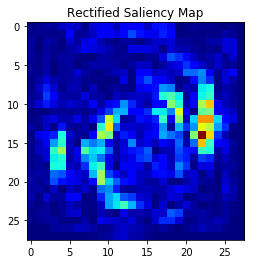

In [ ]:
grads = visualize_saliency(model, layer_idx,
                           filter_indices=class_idx,
                           seed_input=x_test[idx],
                           backprop_modifier="relu")
plt.figure()
plt.title("Rectified Saliency Map")
plt.imshow(grads, "jet")

## Negative Guided Saliency Map

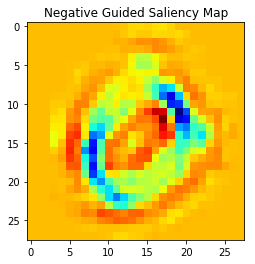

In [ ]:
grads = visualize_saliency(model, layer_idx,
                           filter_indices=class_idx,
                           seed_input=x_test[idx],
                           backprop_modifier="guided",
                           grad_modifier="negate")
plt.figure()
plt.title("Negative Guided Saliency Map")
plt.imshow(grads, cmap="jet")

## Class Saliency Maps

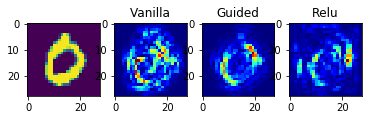

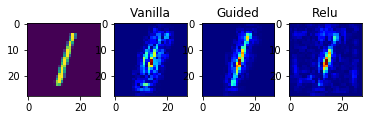

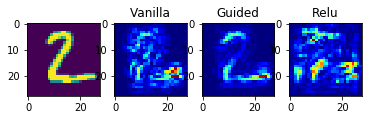

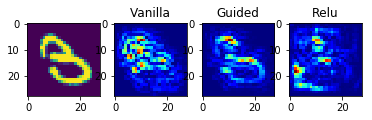

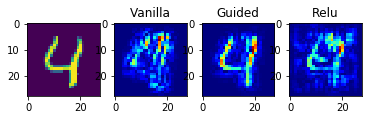

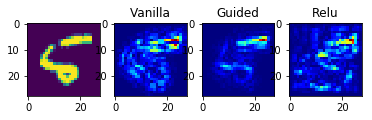

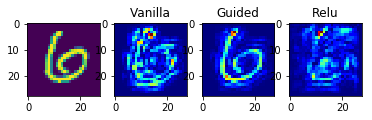

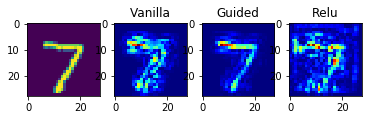

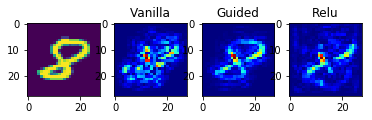

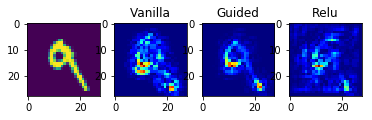

In [ ]:
for class_idx in np.arange(10):
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]
    
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, "guided", "relu"]):
        grads = visualize_saliency(model, layer_idx,
                                   filter_indices=class_idx,
                                   seed_input=x_test[idx],
                                   backprop_modifier=modifier)
        if modifier is None:
            modifier = "vanilla"
        ax[i+1].set_title(modifier.capitalize())
        ax[i+1].imshow(grads, cmap="jet")

## Grad-CAM Saliency Maps

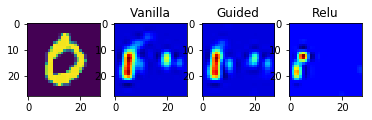

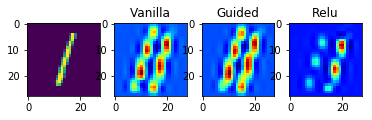

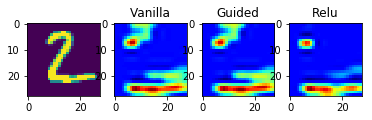

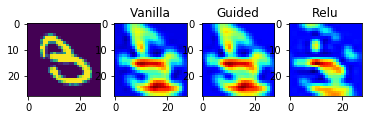

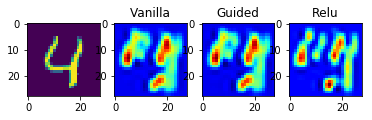

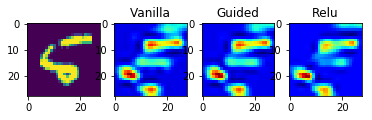

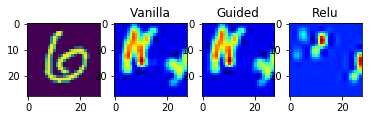

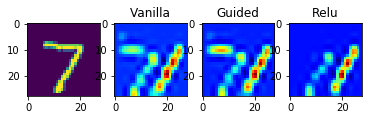

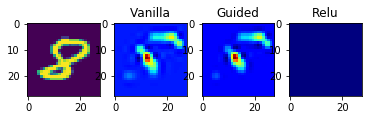

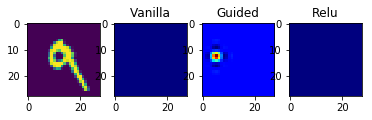

In [ ]:
from vis.visualization import visualize_cam

for class_idx in np.arange(10):
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]
    
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, "guided", "relu"]):
        grads = visualize_cam(model, layer_idx,
                              filter_indices=class_idx,
                              seed_input=x_test[idx],
                              backprop_modifier=modifier)
        if modifier is None:
            modifier = "vanilla"
        ax[i+1].set_title(modifier.capitalize())
        ax[i+1].imshow(grads, cmap="jet")

## Saliency Maps with Softmax Activation

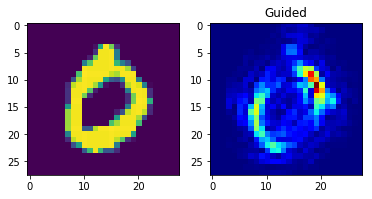

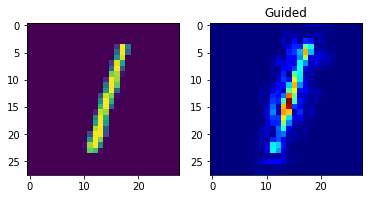

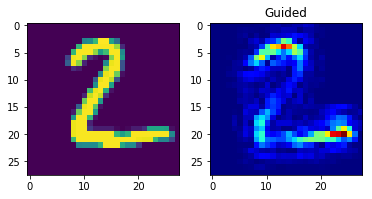

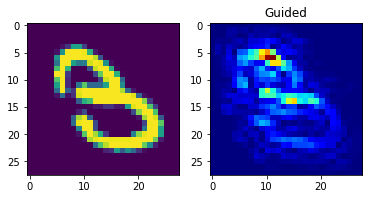

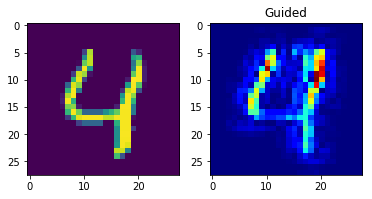

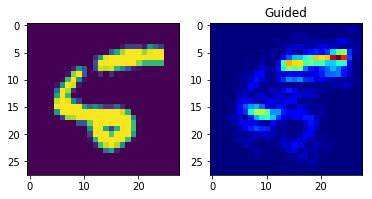

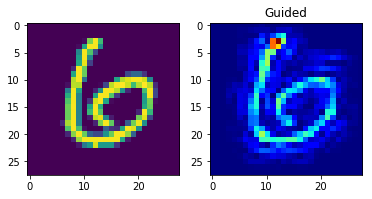

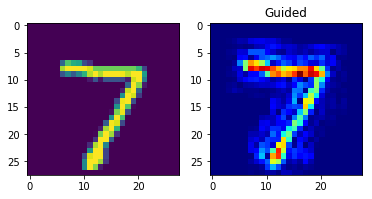

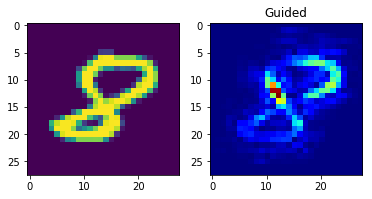

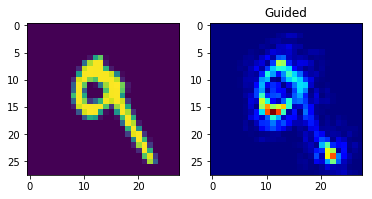

In [ ]:
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

for class_idx in np.arange(10):
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]
    
    grads = visualize_saliency(model, layer_idx,
                               filter_indices=class_idx,
                               seed_input=x_test[idx],
                               backprop_modifier="guided")

    f, ax = plt.subplots(1, 2)
    ax[0].imshow(x_test[idx][..., 0])
    ax[1].set_title("Guided")
    ax[1].imshow(grads, cmap="jet")